In [0]:
import tarfile
with tarfile.open('/content/101_ObjectCategories.tar.gz', 'r:gz') as tar:
    tar.extractall()

In [0]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from keras.applications.vgg16 import VGG16,preprocess_input

def preprocess_img(img_path):
  dsize = (300,200)
  new_image = cv2.imread(img_path)  
  new_image=cv2.resize(new_image,dsize,interpolation=cv2.INTER_NEAREST)  
  new_image=np.expand_dims(new_image,axis=0)
  new_image=preprocess_input(new_image)
  return new_image
        
def load_data():
    output = []
    directory = "/content/101_ObjectCategories" 
    categories=os.listdir(directory)
    #catagories_one_hot = LabelBinarizer().fit_transform(categories)
    for file in os.listdir(directory):
      folder=directory+"/"+file
      for images in os.listdir(folder):
        img_path =folder +"/"+images
        new_image=preprocess_img(img_path)
        output.append(new_image)
    return output
output = load_data()

def limit_data(output):
  X_test=output[99:102]
  X_test=X_test
  output=output[:99]
  X_train=output
  return X_train,X_test

In [0]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.layers import Input
from keras.backend import reshape
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
import cv2

def model():
  model=VGG16(weights='imagenet',include_top=False)
  for layer in model.layers:
    layer.trainable=False
  model.summary()
  return model

def feature_extraction(image_data,model):
  images_feature_vec=[]
  features=model.predict(image_data)
  features=np.array(features)
  features=features.flatten()
  print(features.shape)
  return features

def result_vector(model,feature_vector,new_img):
  new_feature = model.predict(new_img)
  new_feature = np.array(new_feature)
  new_feature = new_feature.flatten()
  N_result = 1
  nbrs = NearestNeighbors(n_neighbors=N_result, metric="cosine").fit(feature_vector)
  distances, indices = nbrs.kneighbors([new_feature])
  return(indices)

def squeeze_dim(data):
  for i in range(len(data)):
    data[i]=np.squeeze(data[i])
    print(data[i].shape)
    return data

def graph_show(data):
  plt.imshow(data)
  plt.show()

def main():  
  features=[]
  output = load_data()
  X_train,X_test=limit_data(output)
  main_model=model()
  for i in X_train:
    features.append(feature_extraction(i,main_model))
  feature_vec = np.array(features)
  result=result_vector(main_model,feature_vec,X_test[0])
  index_result=result[0][0]
  X_train=squeeze_dim(X_train)
  X_test=squeeze_dim(X_test)
  graph_show(X_test[0])
  graph_show(np.squeeze(X_train[index_result]))

if __name__=='__main__':
  main()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


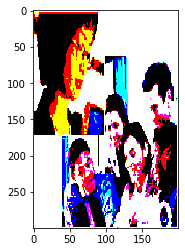

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


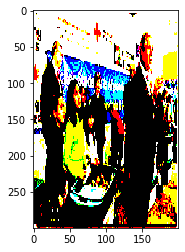

In [0]:

#LSH code taken from https://towardsdatascience.com/finding-similar-images-using-deep-learning-and-locality-sensitive-hashing-9528afee02f5
from lshash import LSHash
k = 10 # hash size
L = 5  # number of tables
d = 27648 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)
# LSH on all the images
for img_path, vec in tqdm_notebook(feature_vec):
    lsh.index(vec.flatten(), extra_data=img_path)
# query a vector q_vec
response = lsh.query(q_vec, num_results= 1)
